In [1]:
import data.dataset
import model.prompter
import utils.eval
import torch

In [2]:
it = data.dataset.get_data_loader("training", "naive_to_rgb", batch_size=1, shuffle=False, device = "cpu", first_only=True)

c:\Users\32427\anaconda3\envs\ver1\lib\site-packages\monai\data\dataset.py:867: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-05-23 23:27:18,158 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-05-23 23:27:19,227 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

model_type = "vit_h"
model_checkpoint = "checkpoint/sam_vit_h_4b8939.pth"

sam = sam_model_registry[model_type](checkpoint=model_checkpoint)
sam_predictor = SamPredictor(sam)

Promptor = model.prompter.Prompter()


In [4]:
import matplotlib.pyplot as plt
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  

def predict(image, label):

    image = image.permute(1, 2, 0).numpy()
    image *= 255
    image = np.array(image, dtype = np.uint8)
    global image2
    image2 = image

    sam_predictor.set_image(image)
    result = np.zeros(label.shape)
    scores = np.zeros(label.shape, dtype = float)
    

    for i in range(1, 14):
        #print(i)
        mask = np.zeros(label.shape, dtype = np.uint8)
        mask[label == i] = 1
        if (np.max(mask) == 0):
            continue
        prompt = Promptor(mask, 1)
        #for j in range(mask.shape[0]):
        #    for k in range(mask.shape[1]):
        #        print(mask[j][k], end = ' ')
        #    print()
        print(prompt)
        msk, score, logit = sam_predictor.predict(**prompt)  

        x, y, z = msk.shape
        msk = msk.reshape(y, z)


        # max_id = 1
        # print(score)

        plt.ion()

        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_points(prompt['point_coords'], prompt['point_labels'], plt.gca())
        plt.axis('on')
        plt.show()  

        print(scores.shape)
        print(msk.shape)
        cond = (scores < score[0]) & msk
        scores[cond] = score[0]
        result[cond] = i

    global res2
    res2 = result

    global ulabel
    ulabel = label.numpy()

    return result


In [5]:
print(utils.eval.evaluate(predict, it))

ZeroDivisionError: float division by zero

1024 1024
(1024, 1024, 3)
255 0


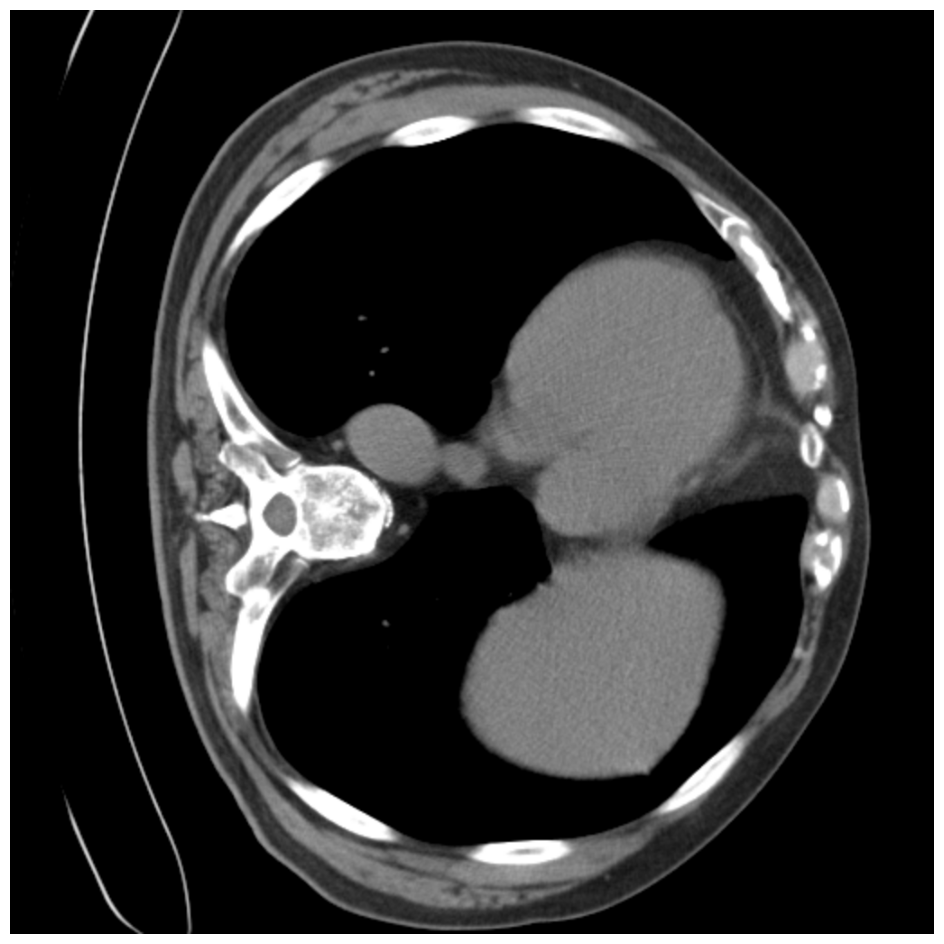

: 

In [ ]:
#x, y = res2.shape
#print(x, y)

#print(image2.shape)

#print(np.max(image2), np.min(image2))

#image3 = ((ulabel == 0)).reshape(x, y, 1) * image2 + (ulabel != 0).reshape(x, y, 1) * (np.array([[[0, 0, 255]]], dtype = float) - image2) / 2

#image3 = np.array(image3, dtype = np.uint8)
#while(True):
#    cv2.imshow("result", image2)
#    cv2.waitKey(10)

#plt.figure(figsize=(12,12))
#plt.axis("off")
#plt.imshow(image2)
#plt.savefig("1.png")
